# **Thermal Waves Experiment**
This jupyter notebook contains the data analysis for the thermal waves section of the script. It contains tasks 1.5 to 1.7.


In [270]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from data_utils import load_dataset, truncate_transient
import re
import os
from IPython.display import Math, display

## **Plane Slab Model of the Cylinder**

The flow of heat in a medium is described by the **heat equation**, which for a plane slab (1-D system) is:

$$
\frac{\partial T(x,t)}{\partial t} = D \frac{\partial^2 T(x,t)}{\partial x^2}
$$

where $T(x,t)$ is the temperature in the medium as a function of space and time, and $D$ is the **thermal diffusivity** of the medium.

Equation (1.1) is a **diffusion equation**, which is a *linear differential equation* like Schrödinger’s equation and the wave equation in the *Electrical Waves* experiment.

---

### Analytical Solution

A solution for $T(x,t)$ that decays in space and oscillates in time with angular frequency $\omega$ is:

$$
T(x,t) = T_0 + C e^{-\sqrt{\frac{\omega}{2D}}\,x}
\sin\!\left(\sqrt{\frac{\omega}{2D}}\,x - \omega t + \phi_0 \right)
$$

where $T_0$, $C$, and $\phi_0$ are constants determined by initial and boundary conditions.

---

### Geometry of the Experiment

In the plane slab model, the brass cylinder is treated as a **1-dimensional slab** of thickness

$$
x_i = i\,\Delta d
$$

with the x-axis along the cylinder’s axis.  

Thermal waves propagate along the x-axis, and the thermistor sensors are placed every $\Delta d = 5~\text{mm}$.

We define $x = 0$ at the first thermistor.


In [271]:
delta_d = 5  # 5 mm spacing between thermistors

## **Task 1.5**

**a)** Write a Python script to extract the phase and amplitude of a single thermistor’s readings. Use this to determine the phase difference and attenuation between the $i = 0$ and $i = 3$ thermistors. Does it agree with your rough estimate from Task 1.4?

---

**b)** Repeat this for all thermistors and plot the attenuation factor against distance.

---

**c)** Find a theoretical form for this function using the plane wave model and fit it to your data to extract the thermal diffusivity, $D$.

---

**d)** Do the same for the phase lag, $\Delta \phi_i$.


#### **Task 1.5 (a) – Extract phase and amplitude from thermistors 0 and 3**
We will load up the $i = 0$ and $i = 3$ data and plot both to inspect form:

In [272]:
save_dir = "mock_data"  # The folder that contains the data
files = [
    "thermal_mock_0p02Hz.csv"
]

Frequency = 0.02000 Hz; BaseAmplitude = 1.50 C; D = 3.50e-05 m^2/s; Sampling = 10.0 Hz
Data shape: (2400, 8), Sampling interval: 0.100 s


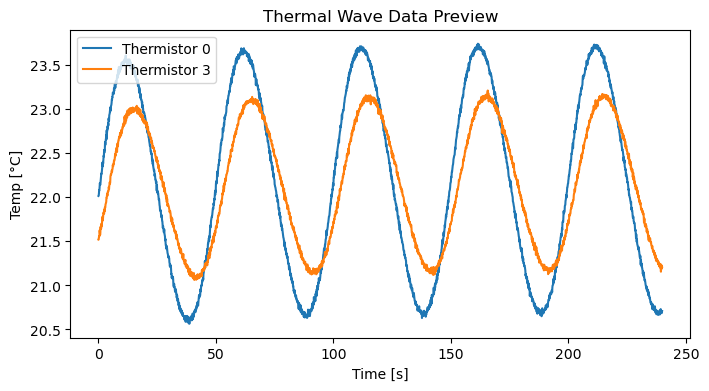

In [273]:
path = os.path.join(save_dir, files[0])  # choose which frequency

timestamp, output_voltage, output_current, Temperatures, comments = load_dataset(path)

print(comments)
print(f"Data shape: {Temperatures.shape}, Sampling interval: {np.mean(np.diff(timestamp)):.3f} s")

# Preview raw data
plt.figure(figsize=(8,4))
plt.plot(timestamp, Temperatures[:,0], label='Thermistor 0')
plt.plot(timestamp, Temperatures[:,2], label='Thermistor 3')
plt.legend(); plt.xlabel('Time [s]'); plt.ylabel('Temp [°C]')
plt.title('Thermal Wave Data Preview'); plt.show()

We will now define functions to extract the amplitude and phase from a single thermistor:

In [274]:
def plane_wave_model(t, T0, A, phi, omega):
    return T0 + A * np.sin(omega * t + phi)

def planewave_curvefit(t, y, omega=None, comments=None):
    """
    Fit one temperature time series to T(t) = T0 + A*sin(ωt + φ).
    If comments string is provided, ω is extracted automatically.
    """
    # --- Optionally extract ω from comment line ---
    if comments is not None and omega is None:
        f_match = re.search(r"Frequency\s*=\s*([\d.]+)", comments)
        if not f_match:
            raise ValueError("Couldn't find frequency in comments.")
        f = float(f_match.group(1))
        omega = 2 * np.pi * f

    if omega is None:
        raise ValueError("You must provide either omega or comments with frequency info.")
    
    # --- Initial guesses ---
    T0_guess  = np.mean(y)
    A_guess   = 0.5 * (np.percentile(y,95) - np.percentile(y,5))
    phi_guess = 0.0

    # --- Fit (ω fixed) ---
    popt, pcov = curve_fit(
        lambda tt, T0, A, phi: plane_wave_model(tt, T0, A, phi, omega),
        t, y,
        p0=[T0_guess, A_guess, phi_guess],
        maxfev=10000
    )

    T0, A, phi = popt
    unc_T0, unc_A, unc_phi = np.sqrt(np.diag(pcov))

    return (T0, unc_T0), (A, unc_A), (phi, unc_phi)

In [275]:
(T0_0, unc_T0_0), (A0, unc_A0), (phi0, unc_phi0) = planewave_curvefit(timestamp, Temperatures[:,0], comments=comments)

(T0_3, unc_T0_3), (A3, unc_A3), (phi3, unc_phi3) = planewave_curvefit(timestamp, Temperatures[:,3], comments=comments)
print()

display(Math(rf"A_0 = {A0:.4f} \pm {unc_A0:.4f}\ \text{{°C}}"))
display(Math(rf"\phi_0 = {phi0:.4f} \pm {unc_phi0:.4f}\ \text{{rad}}"))
display(Math(""))
display(Math(rf"A_3 = {A3:.4f} \pm {unc_A3:.4f}\ \text{{°C}}"))
display(Math(rf"\phi_3 = {phi3:.4f} \pm {unc_phi3:.4f}\ \text{{rad}}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

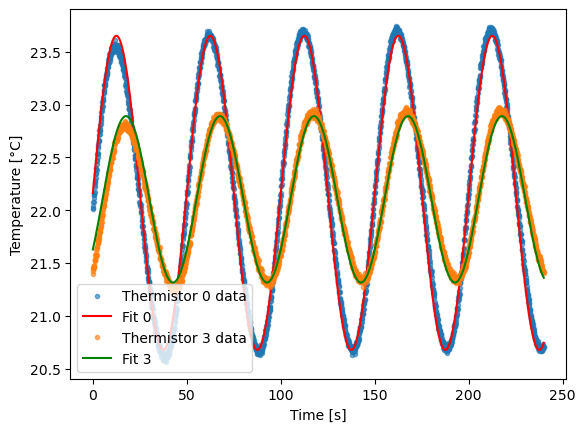

In [276]:
f_match = re.search(r"Frequency\s*=\s*([\d.]+)", comments)
f = float(f_match.group(1))
omega = 2 * np.pi * f

plt.plot(timestamp, Temperatures[:,0], '.', label='Thermistor 0 data', alpha=0.6)
plt.plot(timestamp, plane_wave_model(timestamp, T0_0, A0, phi0, omega), 'r-', label='Fit 0')

plt.plot(timestamp, Temperatures[:,3], '.', label='Thermistor 3 data', alpha=0.6)
plt.plot(timestamp, plane_wave_model(timestamp, T0_3, A3, phi3, omega), 'g-', label='Fit 3')

plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.show()

Define functions to determine attenuation factor and phase difference:

In [277]:
def attenuation_factor(A1, unc_A1, A2, unc_A2):
    """
    Compute the attenuation factor gamma = A2 / A1 and its uncertainty.
    """
    g = A2 / A1
    unc_g = g * np.sqrt((unc_A2/A2)**2 + (unc_A1/A1)**2)
    return g, unc_g

def phase_difference(phi1, unc_phi1, phi2, unc_phi2):
    """
    Compute the phase difference Δφ = φ2 - φ1 and its uncertainty.
    """
    dphi = phi2 - phi1
    unc_dphi = np.sqrt(unc_phi1**2 + unc_phi2**2)
    return dphi, unc_dphi

In [278]:
g, unc_g = attenuation_factor(A0, unc_A0, A3, unc_A3)
dphi, unc_dphi = phase_difference(phi0, unc_phi0, phi3, unc_phi3)

display(Math(rf"\gamma_3 = {g:.4f} \pm {unc_g:.4f}\ \text{{°C}}"))
display(Math(rf"\Delta\phi_3 = {dphi:.4f} \pm {unc_dphi:.4f}\ \text{{rad}}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### **Task 1.5 (b) – Extract transmission factor for all thermistors and plot them**
We now fit **all thermistors** with the same sinusoidal model to extract their
amplitudes $A_i$ and phases $\phi_i$, then compute the attenuation factor
$\gamma_i = A_i / A_0$ and plot it against distance $x_i = i \Delta d$.

In [279]:
n_therm = Temperatures.shape[1]

amps = np.zeros(n_therm)
unc_amps = np.zeros(n_therm)
phases = np.zeros(n_therm)
unc_phases = np.zeros(n_therm)

for i in range(n_therm):
    # Optionally truncate transients for each thermistor
    t_trunc, T_trunc = truncate_transient(timestamp, Temperatures[:, i], verbose=False)

    (_, _), (A, unc_A), (phi, unc_phi) = planewave_curvefit(
        t_trunc, T_trunc,
        comments=comments  # extracts ω from comment string
    )

    amps[i] = A
    unc_amps[i] = unc_A
    phases[i] = phi
    unc_phases[i] = unc_phi

print("Amplitudes A_i:", amps)
print("Phases phi_i  :", phases)


Amplitudes A_i: [1.48537823 1.20085212 0.971333   0.78726827 0.6386488  0.5186142
 0.4224391  0.34511063]
Phases phi_i  : [-1.50472881e-03 -2.14961010e-01 -4.30074537e-01 -6.46486925e-01
 -8.63356933e-01 -1.08130112e+00 -1.29618020e+00 -1.51413950e+00]


In [280]:
# Thermistor indices and distances
i_vals = np.arange(n_therm)  # i = 0,1,2,...
x = i_vals * delta_d  # x_i = i * Δd  (in mm)

# Attenuation factors γ_i = A_i / A_0
gamma = amps / amps[0]
unc_gamma = gamma * np.sqrt(
    (unc_amps / amps) ** 2 + (unc_amps[0] / amps[0]) ** 2
)
# Compute phase lag relative to thermistor 0
dphi = phases - phases[0]
unc_dphi = np.sqrt(unc_phases**2 + unc_phases[0]**2)


print("Attenuation factors γ_i:", gamma)
print("Phase lags dphi_i:", dphi)


Attenuation factors γ_i: [1.         0.80844872 0.65392974 0.53001199 0.42995702 0.34914622
 0.28439834 0.23233855]
Phase lags dphi_i: [ 0.         -0.21345628 -0.42856981 -0.6449822  -0.8618522  -1.07979639
 -1.29467547 -1.51263477]


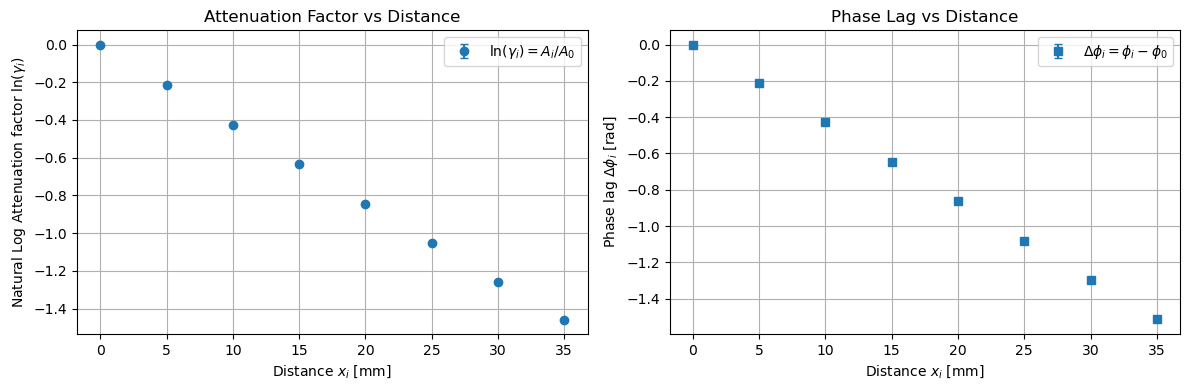

In [281]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# ------------------------- LEFT PLOT -------------------------
ax = axes[0]
ax.errorbar(
    x, np.log(gamma),
    yerr=unc_gamma,
    fmt='o', capsize=3,
    label=r'$\ln(\gamma_i) = A_i/A_0$'
)

ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel(r"Natural Log Attenuation factor $\ln(\gamma_i)$")
ax.set_title("Attenuation Factor vs Distance")
ax.grid(True)
ax.legend()

# ------------------------- RIGHT PLOT ------------------------
ax = axes[1]
ax.errorbar(
    x, dphi,
    yerr=unc_dphi,
    fmt='s', capsize=3,
    label=r'$\Delta\phi_i = \phi_i - \phi_0$',
)

ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel(r"Phase lag $\Delta\phi_i$ [rad]")
ax.set_title("Phase Lag vs Distance")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


#### **Task 1.5 (c) – Fit attenuation vs distance to extract $D$**

From the plane-wave solution, the attenuation factor 

$$
\ln(\gamma_i) = -\sqrt{\frac{\omega}{2D}} \, (i\Delta d)
$$

where $x_i = i \Delta d$, so we fit

$$
\ln(\gamma_i) = k_{\gamma} \, x_i
$$

and compute the diffusivity:

$$
D = \frac{\omega}{2 k_{\gamma}^2}.
$$

---

#### **Task 1.5 (d) – Fit phase lag vs distance to extract $D$**

The theoretical phase lag is

$$
\Delta\phi_i = \sqrt{\frac{\omega}{2D}} \, (i\Delta d),
$$

where $x_i = i \Delta d$, so we fit

$$
\Delta\phi_i = k_{\phi} \, x_i.
$$

Thus,

$$
D = \frac{\omega}{2 k_{\phi}^2}.
$$
